In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from qdrant_client.http import models
from myAgent.qdrant import qdrant
from myAgent.ollama import embed
import json

tab = pd.read_csv("pkm.csv")
tab[:3]

,id,description,nom,type
0,1,"Au matin de sa vie, la graine sur\r\nson dos l...",Bulbizarre,Pokémon Graine
1,1,Il a une étrange graine plantée sur son dos.\r...,Bulbizarre,Pokémon Graine
2,1,"Au matin de sa vie, la graine sur son dos lui ...",Bulbizarre,Pokémon Graine


In [2]:
qdrant.delete_collection(collection_name="pokemons")
qdrant.create_collection(
    collection_name="pokemons",
    vectors_config=models.VectorParams(
        size= len(embed("lorem ipsum")),
        distance=models.Distance.COSINE
    )
)
qdrant.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='pokemons')])

In [3]:
for id in tab["id"].unique():
    
    tmp = tab[tab["id"] == id]
    nom = tmp["nom"].iloc[0]
    type = tmp["type"].iloc[0]
    description = ""
    for j in range(len(tmp)):
        description = description + tmp["description"].iloc[j] + " "
    description = description.replace("\r", "").replace("\n", " ")
    prompt = nom + " est un " + type + ". " + description

    if id == 25:
        print(prompt[:300] + " [...]")

    vector = embed(prompt)
    
    qdrant.upsert(
        collection_name="pokemons",
        points=[
            models.PointStruct(
                id = int(id),
                vector = vector,
                payload={
                    "numero": int(id),
                    "nom": nom,
                    "type": type,
                    "description": description,
                }
            )
        ]
    )

Pikachu est un Pokémon Souris. Il lui arrive de remettre d’aplomb un Pikachu allié en lui envoyant une décharge électrique. Il élève sa queue pour surveiller les environs. Elle attire souvent la foudre dans cette position. Pikachu a de petites poches pleines d’électricité sur ses joues. S’il se sent [...]


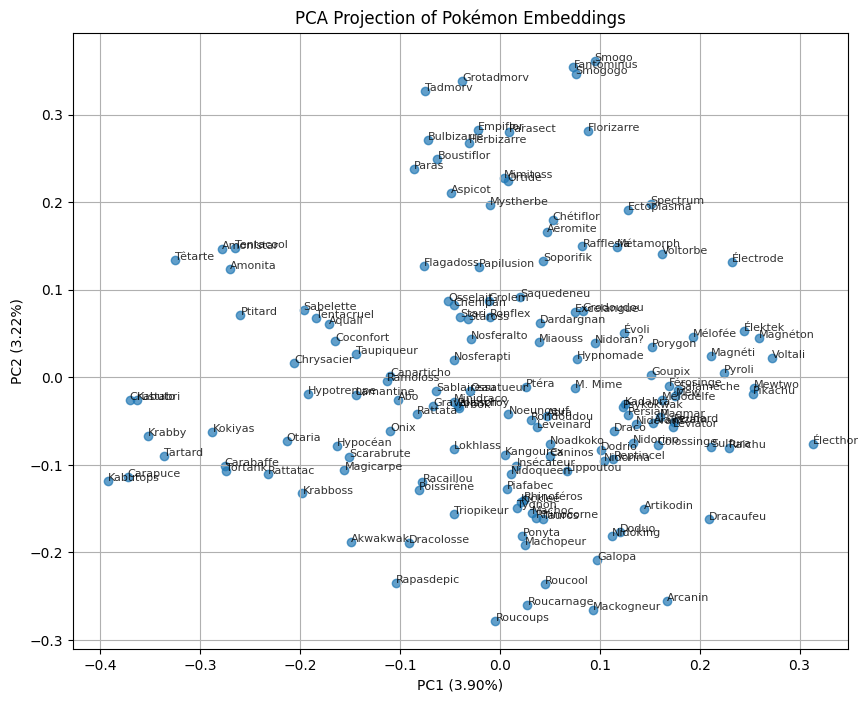

In [4]:
all_points = qdrant.scroll(
    collection_name="pokemons",
    limit=151,
    with_payload=True,
    with_vectors=True
)[0]
embeddings = []
ids = []
for point in all_points:
    embeddings.append(point.vector)
    ids.append(point.payload.get("nom", point.id))
embeddings = np.array(embeddings)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
explained_variance = pca.explained_variance_ratio_ * 100
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
for i, name in enumerate(ids):
    plt.annotate(name, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.8)
plt.xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"PC2 ({explained_variance[1]:.2f}%)")
plt.title("PCA Projection of Pokémon Embeddings")
plt.grid(True)
plt.show()